In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
diabetes_df = pd.read_csv('diabetes_prediction_dataset.csv')

## Exploration of Data

In [3]:
diabetes_df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [4]:
diabetes_df.info() #Displays the information of the dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [5]:
diabetes_df.describe() #Gives statistical data

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [6]:
diabetes_df.isnull().sum() #checks for missing/null values

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [7]:
diabetes_df.duplicated().sum() #checks for duplicate values

3854

In [8]:
#Encode categorical variables (gender, smoknig history)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

categorical_columns = ['gender', 'smoking_history']
for column in categorical_columns:
    diabetes_df[column] = LabelEncoder().fit_transform(diabetes_df[column])

In [9]:
#TODO Find/show anomalies (we have to find which columns to investigate or investigate all of them)

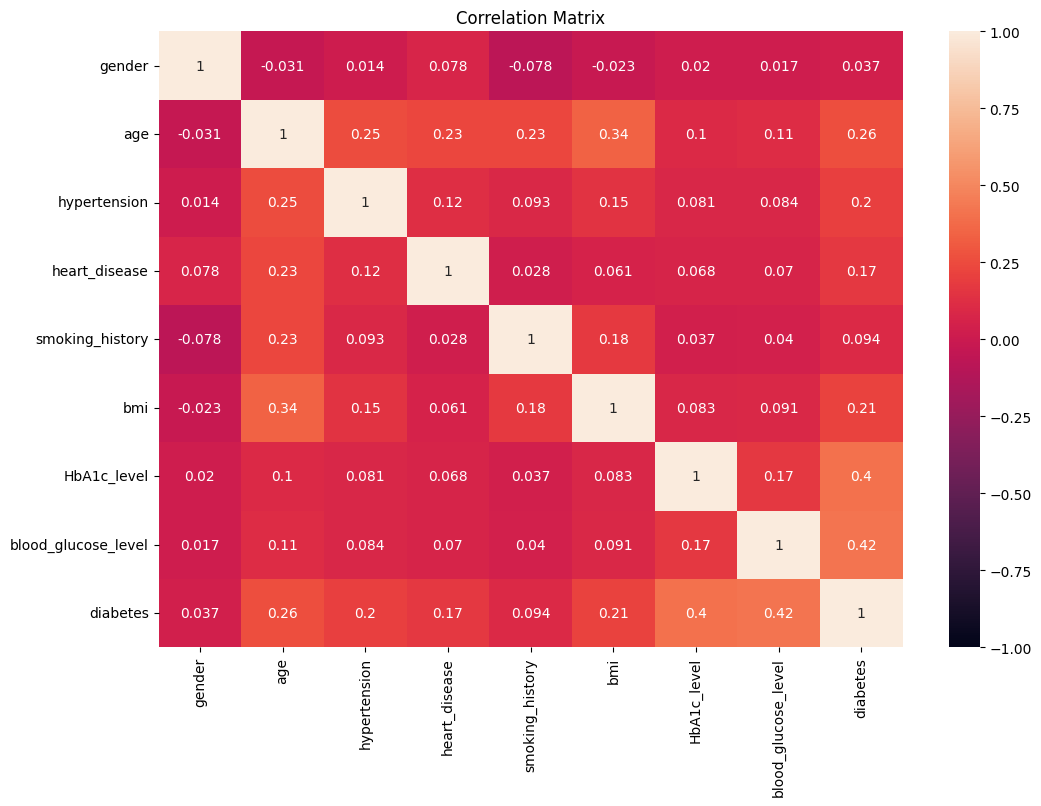

In [10]:
#Correlation Matrxi
plt.figure(figsize=(12, 8))
correlation_matrix = diabetes_df.corr()
sb.heatmap(correlation_matrix, annot=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

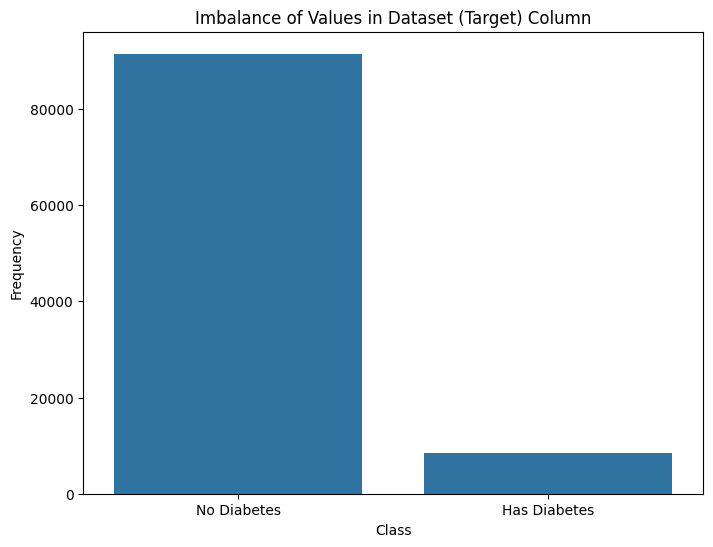

In [11]:
#Display class imbalance

#grab counts
counts = diabetes_df[diabetes_df.columns[-1]].value_counts()

# Plot the imbalance
plt.figure(figsize=(8, 6))
sb.barplot(x=counts.index, y=counts.values)
plt.title('Imbalance of Values in Dataset (Target) Column')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['No Diabetes', 'Has Diabetes'])
plt.show()

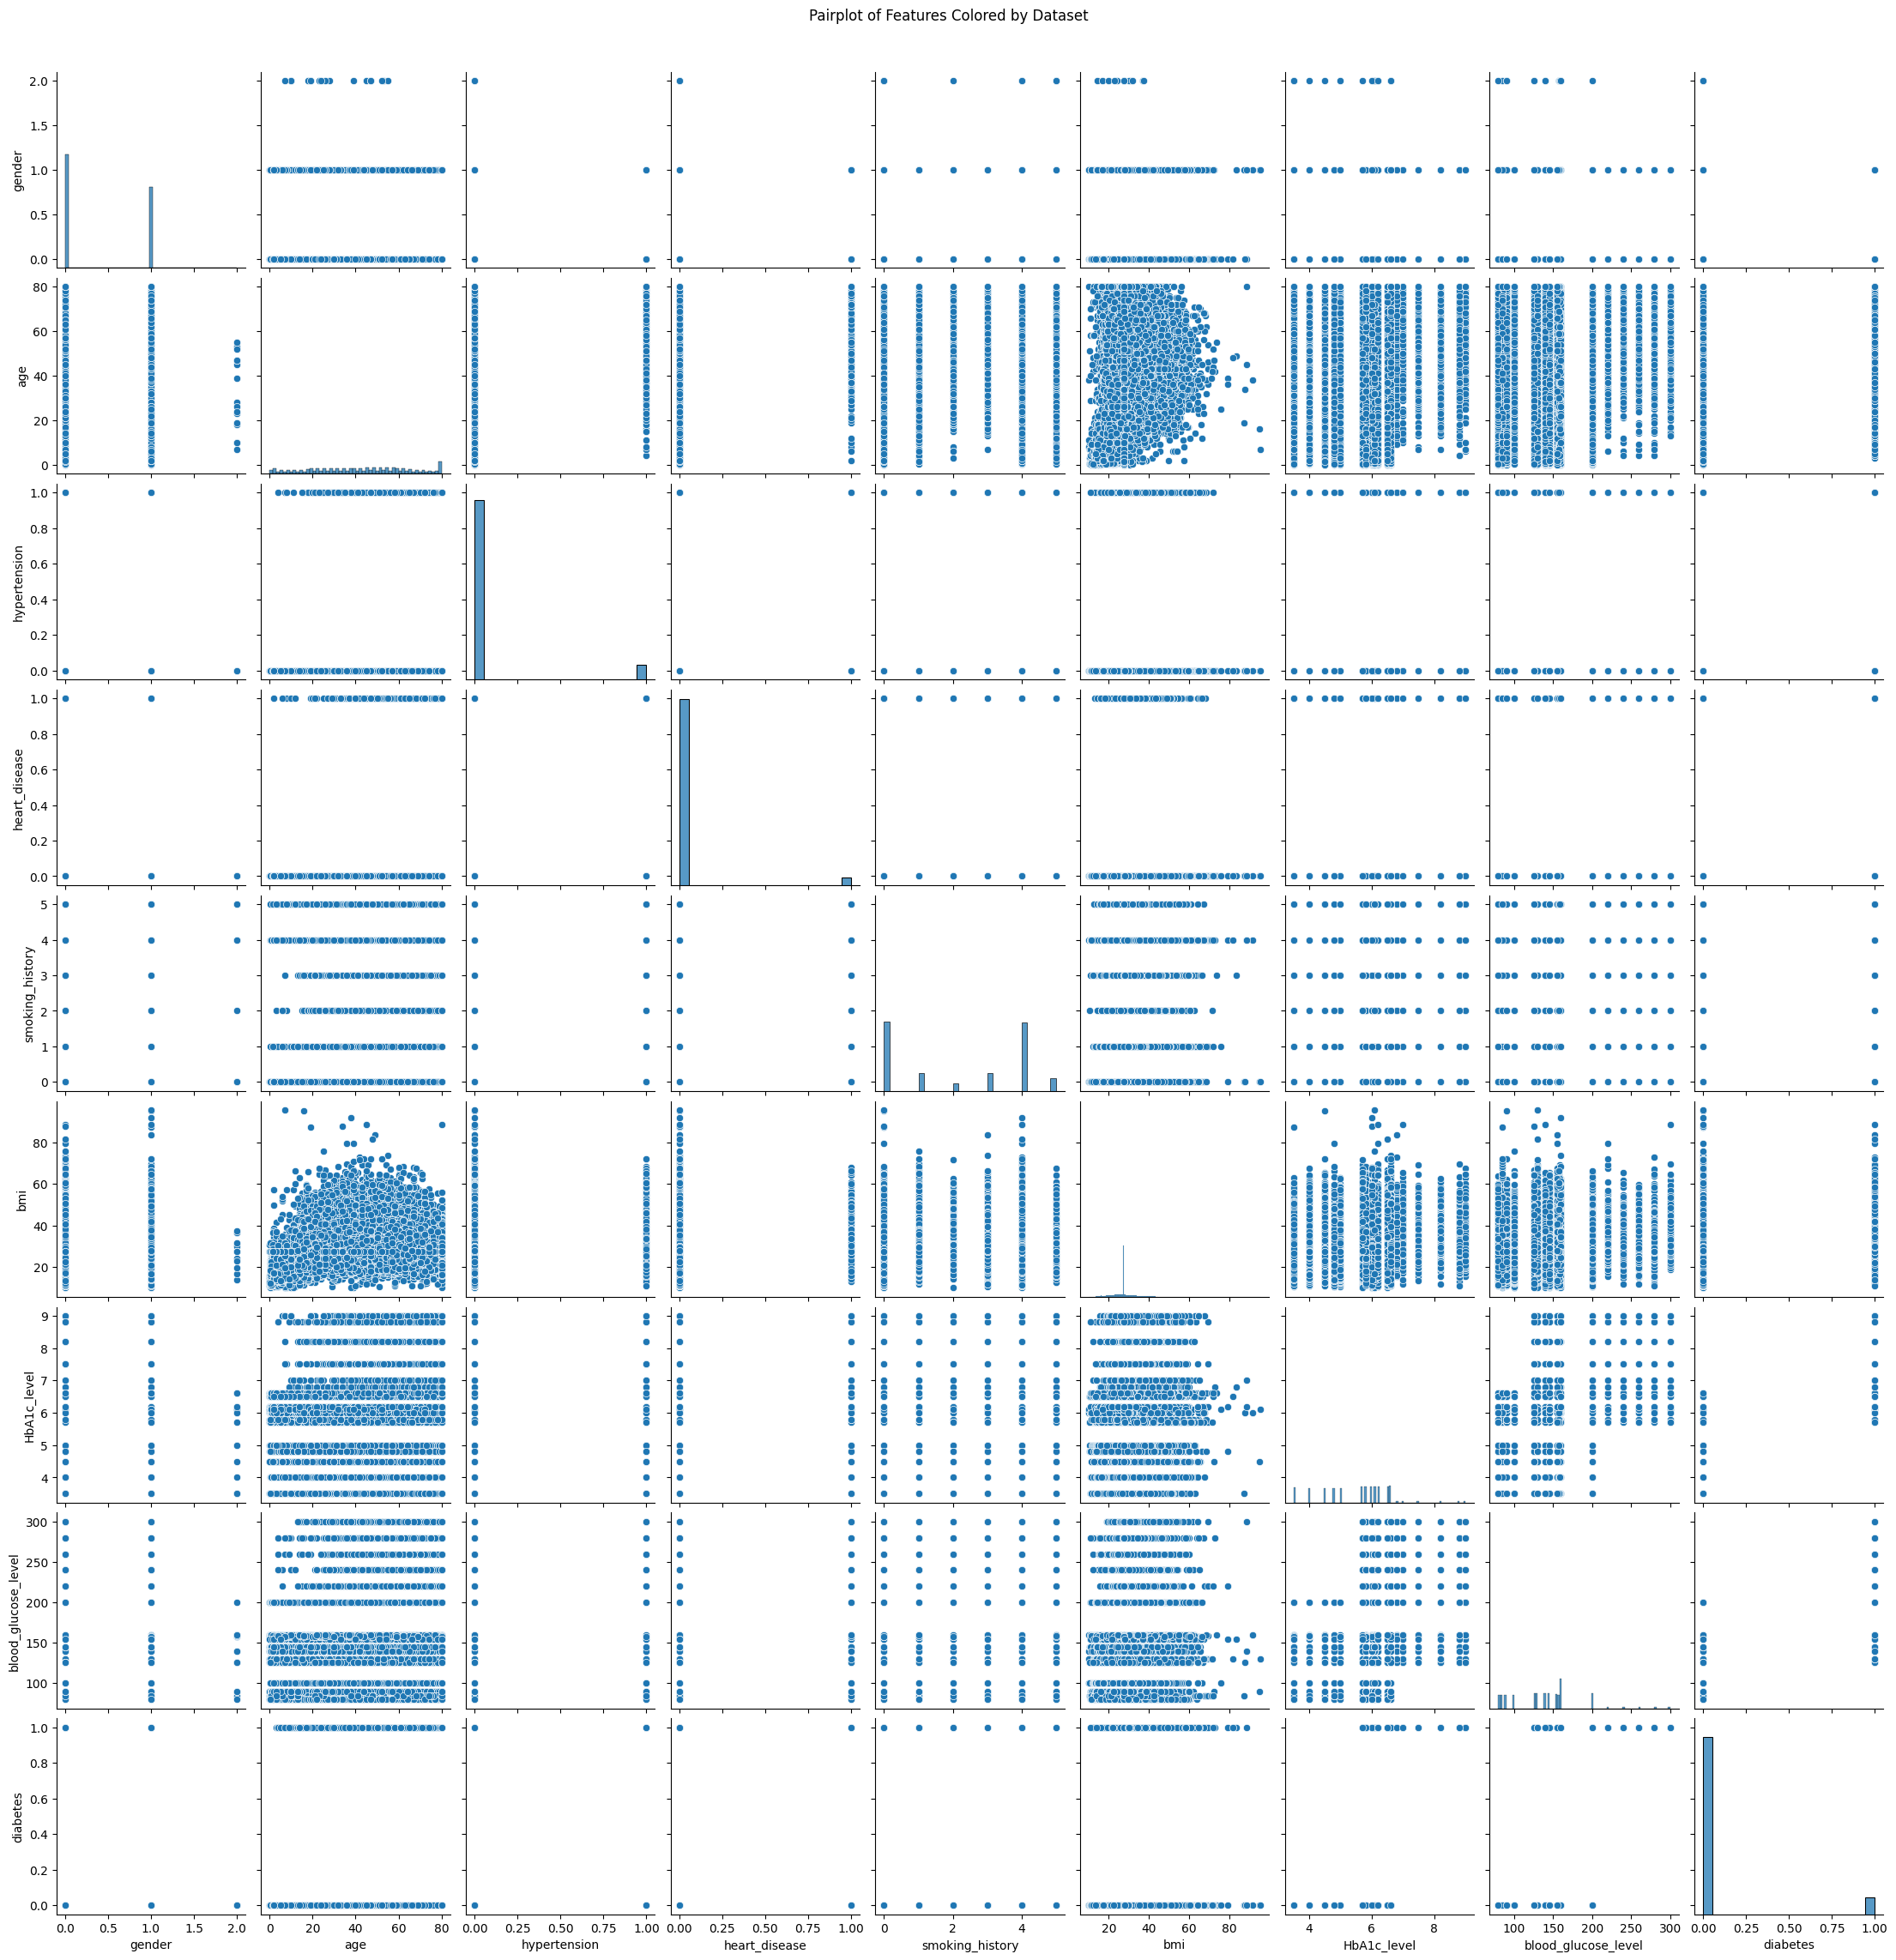

In [12]:
#Explore the data using visualization TODO add more visualizations

#Pairplot
sb.pairplot(diabetes_df)
plt.suptitle('Pairplot of Features Colored by Dataset', y=1.02)
plt.show()

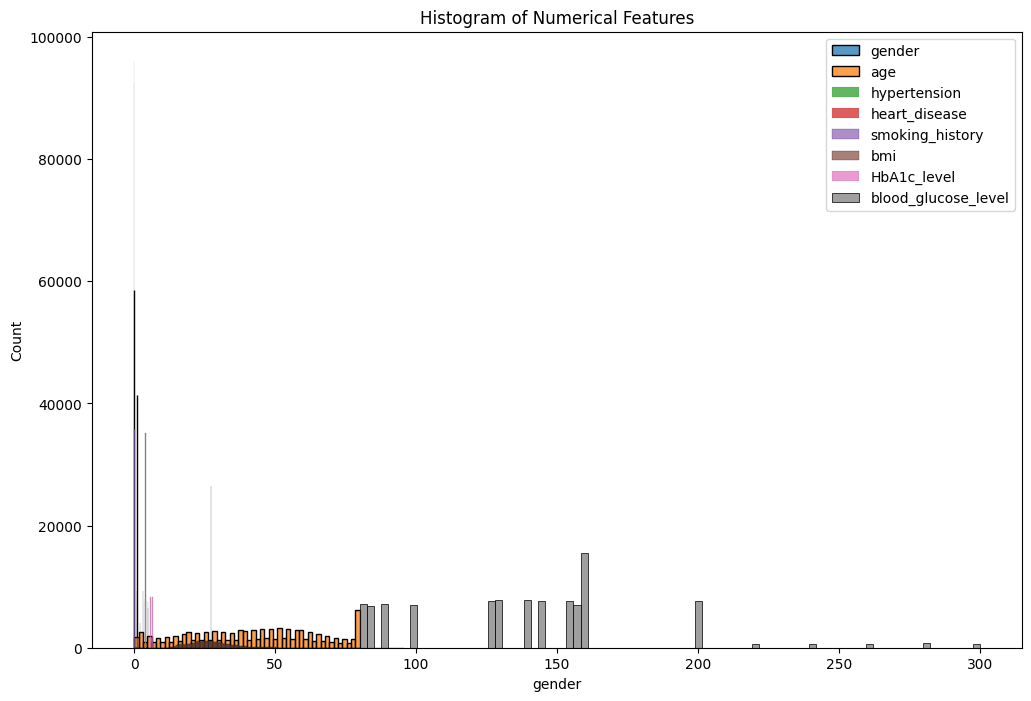

In [13]:
#histoplot
plt.figure(figsize=(12, 8))
for column in diabetes_df.columns[:-1]:  # Exclude the target column
    sb.histplot(diabetes_df[column], label=column)
plt.title('Histogram of Numerical Features')
plt.legend()
plt.show()

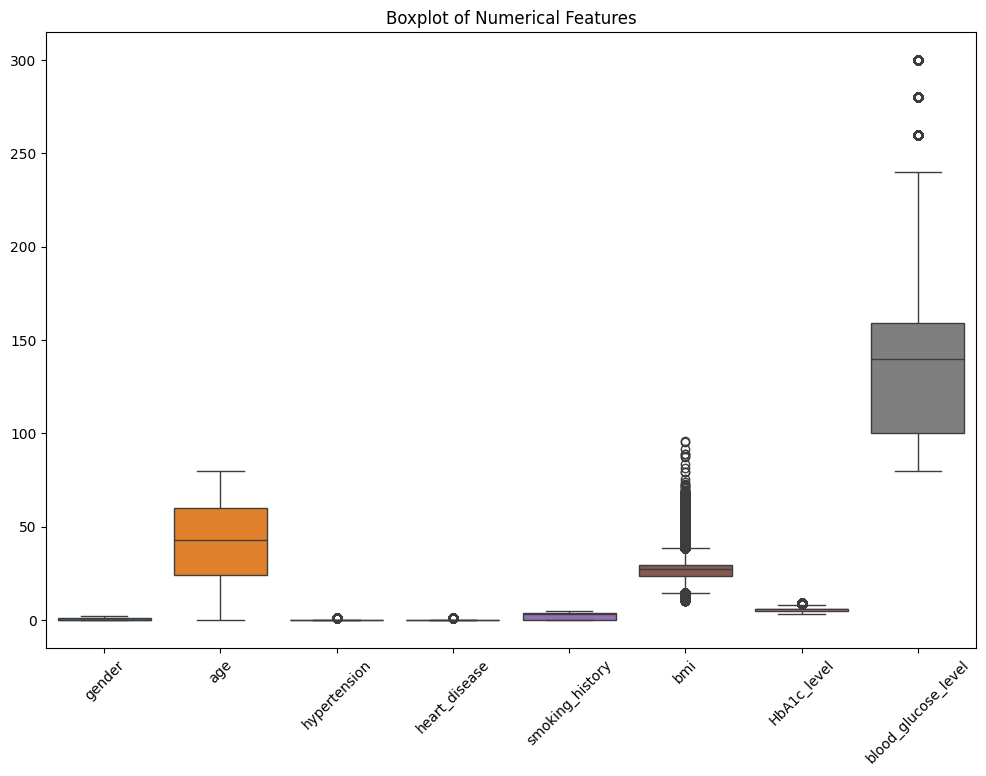

In [14]:
#Boxplot
plt.figure(figsize=(12, 8))
sb.boxplot(data=diabetes_df.drop(columns=['diabetes']))
plt.title('Boxplot of Numerical Features')
plt.xticks(rotation=45)
plt.show()

## Preprocessing of Data

In [15]:
diabetes_df = diabetes_df.drop_duplicates(keep='first') # drops the duplicate entries in the data set

diabetes_df.duplicated().sum()

0

In [16]:
#TODO Remove anomalies if any

In [17]:
#splitting target from data
data = diabetes_df[diabetes_df.columns[:-1]]
target = diabetes_df[diabetes_df.columns[-1]]

In [18]:
from sklearn.preprocessing import StandardScaler 

# Initializes StandardScaler
scaler = StandardScaler()

# Fit and transform the data 
scaled_data = scaler.fit_transform(data)

In [19]:
#Balance classes with SMOTE
import imblearn
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
x,y = sm.fit_resample(scaled_data, target)

In [20]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((140262, 8), (35066, 8), (140262,), (35066,))

## Training the Models

In [21]:
#Logistic regression
#Naives bayes
#KNN
#Random forest
#Decision tree
#Bagging
#AdaBoost
#XGBoost
#Voting
#SVM
#Neural Network
#Deep Neural Network

#Top Models we will run
#GridSearchCV
#RFE feature selection

### Standalone Models

In [22]:
#Logistic Regression - Vance
from sklearn.linear_model import LogisticRegression

Logistic_regression_model = LogisticRegression(random_state=42).fit(X_train, y_train)

pred_log_reg = Logistic_regression_model.predict(X_test)

In [23]:
#Naive Bayes - Jesus

In [24]:
#KNN - Joshua

In [25]:
#Random Forest - Joshua

In [26]:
#SVM - Jesus

In [27]:
#Decision Tree - Vance
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=4)
decision_tree.fit(X_train,y_train)

pred_decision_tree = decision_tree.predict(X_test)

In [35]:
#Neural Network
#https://keras.io/examples/structured_data/structured_data_classification_with_feature_space/
import keras
from keras import layers
from keras import ops, models, optimizers
from keras.utils import FeatureSpace

# Assuming X_train, y_train, X_test, y_test are already defined and preprocessed
input_shape = X_train.shape[1:]

simple_NN = models.Sequential(
    [
    layers.Input(shape=input_shape),
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # For binary classification
    ]
)

simple_NN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
simple_NN.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Make predictions
pred_simple_NN = simple_NN.predict(X_test)

Epoch 1/10
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 5s 902us/step - accuracy: 0.8859 - loss: 0.2479 - val_accuracy: 0.9069 - val_loss: 0.1905
Epoch 2/10
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 4s 923us/step - accuracy: 0.9090 - loss: 0.1878 - val_accuracy: 0.9114 - val_loss: 0.1816
Epoch 3/10
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 4s 908us/step - accuracy: 0.9125 - loss: 0.1811 - val_accuracy: 0.9109 - val_loss: 0.1797
Epoch 4/10
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 4s 872us/step - accuracy: 0.9131 - loss: 0.1779 - val_accuracy: 0.9104 - val_loss: 0.1780
Epoch 5/10
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 4s 857us/step - accuracy: 0.9144 - loss: 0.1749 - val_accuracy: 0.9125 - val_loss: 0.1757
Epoch 6/10
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 4s 935us/step - accuracy: 0.9150 - loss: 0.1741 - val_accuracy: 0.9127 - val_loss: 0.1741
Epoch 7/10
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 4s 973us/step - accuracy: 0.9154 - loss: 0.1720 - val_accuracy: 0.9131 - val_loss: 0.1750
Epoch 8/10
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 4s 964us/step - accuracy: 0.9170 -

### Combination Models

In [ ]:
#Bagging - 

In [ ]:
#AdaBoost - 

In [ ]:
#XGBoost - 

In [ ]:
#Voting - 

## Comparing the Models

https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, matthews_corrcoef

def evaluate(y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    mtc = matthews_corrcoef(y_test, y_pred)

    results = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'AUC': auc,
        #'Matthews Corr Coef': mtc,
    }

    return results

def evaluateNN():
    return None

def displayCM(y_pred):
    # Generate matrix
    cm = confusion_matrix(y_test, y_pred)
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Diabetes (1)', 'No Diabetes (0)'])
    disp.plot()
    plt.title('Confusion Matrix Tree')
    plt.show()

def displayResultsTable(modelResults):
    df = pd.DataFrame(modelResults).T
    print(df)

def findTopModel(modelResults, metricName):
    #find top model based on F1
    top_model = None
    top_score = 0
    for model_name, metrics in modelResults.items():
        if metrics[metricName] > top_score:
            top_score = metrics[metricName]
            top_model = model_name
    return top_model, top_score

In [61]:
logistic_regression = evaluate(pred_log_reg)

decision_tree = evaluate(pred_decision_tree)

#neural_network = evaluate(pred_simple_NN)

#deep_neural_network = evaluate(pred_deep_NN)

modelResults = {
    'Logistic Regression': logistic_regression,
    'Decision Tree': decision_tree,
    #'Neural Network': neural_network,
    #'Deep Neural Network': deep_neural_network
}

displayResultsTable(modelResults)

top_f1_model, top_f1_score = findTopModel(modelResults,'F1')
print()
print(f'The model with the highest F1 score is {top_f1_model} with a score of {top_f1_score:.4f}')

                     Accuracy  Precision    Recall        F1       AUC
Logistic Regression  0.885131   0.888921  0.881659  0.885275  0.885150
Decision Tree        0.846974   0.780047  0.968741  0.864214  0.846318

The model with the highest F1 score is Logistic Regression with a score of 0.8853


## Feature Selection & GridSearchCV on the Top Models

## Recomparing the Models

## Final Observations